# Simulator demo

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('../src')) # or the path to your source code
sys.path.insert(0, module_path)

import epinorm.data as data
import epinorm.simulation as sim
import scanpy as sc
import episcanpy as epi
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import epinorm.plots as myplt
import numpy as np
from pathlib import Path

In [2]:
file_path=Path('data/mouse_brain_5k/bin_by_cell_filtered.h5ad')

In [3]:
epidata = data.MouseBrainDataset()
adata = epidata.load_mtx(matrix_path=file_path)

In [4]:
adata

AnnData object with n_obs × n_vars = 3649 × 15032
    obs: 'cell_type', 'protocol', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'nucleosome_signal', 'tss_enrichment_score', 'tss', 'passes_filter'
    var: 'chr', 'start', 'stop', 'n_cells', 'log_n_cells', 'passes_filter'
    uns: 'fragment_lengths', 'tss_enrichment'

In [5]:
annotation_name = 'cell_type'
simulation_params = sim.Params(ncells=50, noise_mean=-0.3, noise_sd=0.3)
adata_sim = sim.simulate_by_annotation(adata, simulation_params, annotation_name=annotation_name)

In [9]:
adata_sim

AnnData object with n_obs × n_vars = 550 × 15032
    obs: 'Cell', 'LibSize', 'cell_type'
    var: 'chr', 'start', 'stop', 'n_cells', 'log_n_cells', 'passes_filter'

In [30]:
with sim.Simulator() as simulator:
    simulator.estimate(adata[adata.obs.cell_type == 'L5 IT'])
    tmp = simulator.parameters.non_zero_prob

In [39]:
np.max(tmp)

0.9879154078549849

In [40]:
np.min(tmp)

0.0

In [41]:
np.mean(tmp)

0.446267499425194

In [29]:
# np.log2(adata_sim.obs.LibSize)
df = adata_sim.obs.set_index('cell_type')
print(df[~df.index.duplicated(keep='first')].LibSize)
print(np.log2(df[~df.index.duplicated(keep='first')].LibSize))

cell_type
Pvalb            22051.251743
L5 PT            27030.322509
NP               14314.889128
L6 CT            18428.479559
No annotation     8334.574351
Vip               5737.571893
L2/3 IT          24078.188423
Sst              12005.059156
L5 IT            19477.514924
L4               16994.450893
L6 IT            17957.240245
Name: LibSize, dtype: float64
cell_type
Pvalb            14.428573
L5 PT            14.722291
NP               13.805229
L6 CT            14.169649
No annotation    13.024893
Vip              12.486225
L2/3 IT          14.555439
Sst              13.551355
L5 IT            14.249522
L4               14.052776
L6 IT            14.132278
Name: LibSize, dtype: float64


## Simulated lib size

In [8]:
adata_sim.obs['actualLibSize'] = np.ravel(adata_sim.X.sum(1))

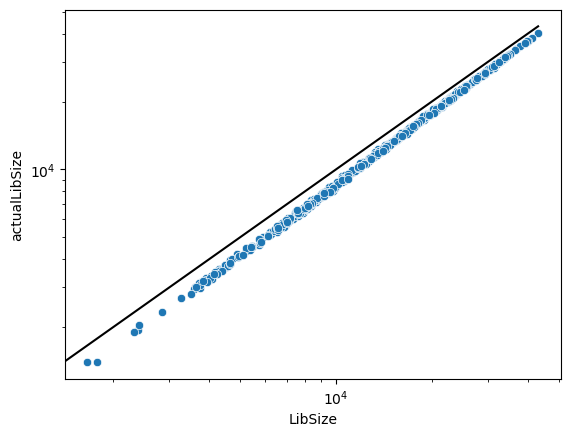

In [9]:
fig = plt.figure()
ax = fig.add_subplot()
sns.scatterplot(adata_sim.obs, x='LibSize', y='actualLibSize', ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')
_max = np.max(adata_sim.obs['LibSize'])
ax.plot((0,_max), (0,_max),color='black')

In [10]:
epi.pp.qc_stats(adata_sim, verbose=True)

added keys n_cells, log_n_cells to .var
added keys n_features, log_n_features, n_counts, log_n_counts to .obs


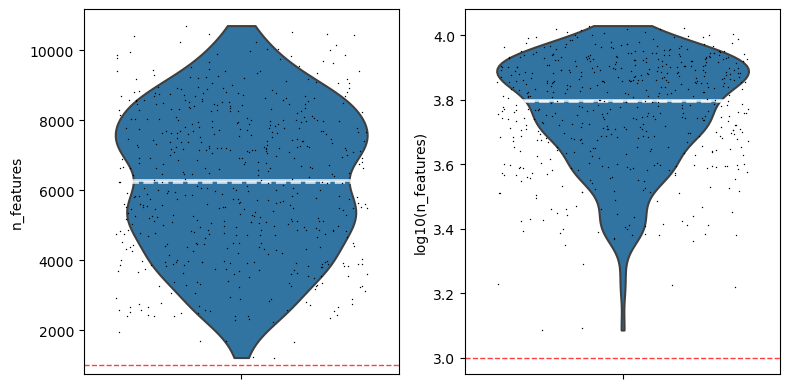

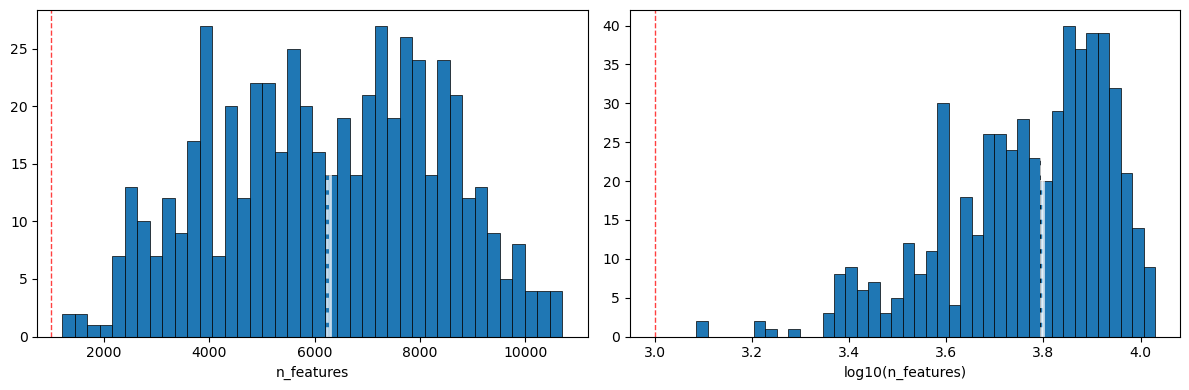

Max:	10706
Median:	6291.5
Mean:	6232.32
Min:	1217


In [11]:
min_features = 1000
max_features = None

epi.pl.violin(adata_sim, "n_features", min_threshold=min_features, max_threshold=max_features, show_log=True, show_mean=True, show_median=True, print_statistics=False, save=None)
epi.pl.histogram(adata_sim, "n_features", bins=40, min_threshold=min_features, max_threshold=max_features, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

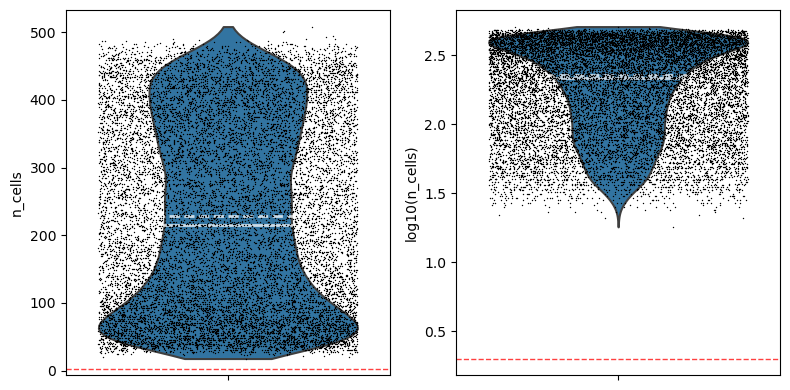

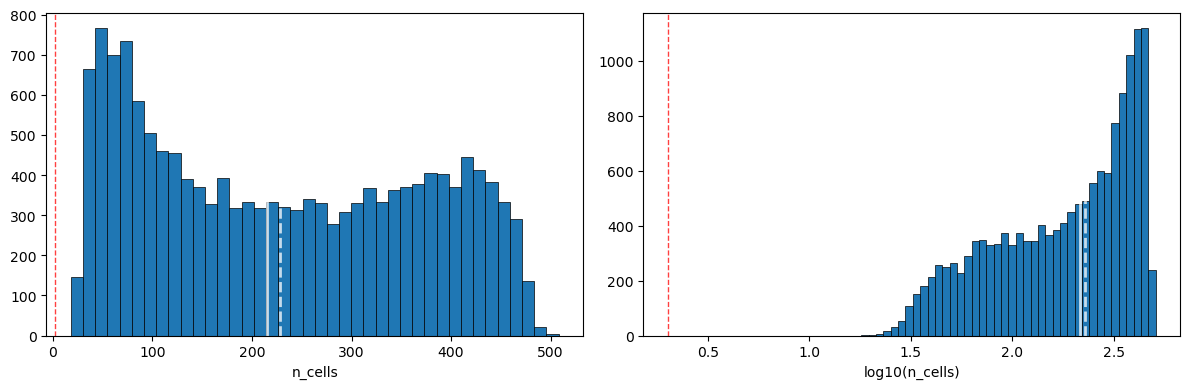

Max:	508
Median:	215.0
Mean:	228.03193187865887
Min:	18


In [12]:
min_cells = 2
max_cells = None

epi.pl.violin(adata_sim, "n_cells", min_threshold=min_cells, max_threshold=max_cells, show_log=True, show_mean=True, show_median=True, print_statistics=False, save=None)
epi.pl.histogram(adata_sim, "n_cells", bins=40, min_threshold=min_cells, max_threshold=max_cells, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

### Set, check, and apply filters

In [13]:
adata_sim.write_h5ad(file_path.parent / (file_path.stem + '_simulated.h5ad'))